In [132]:
import numpy as np
import matplotlib.pyplot as plt

In [133]:
path = "/home/dan/Documents/images/offline-run-20240124_114804-2mqc2q1n/files/self_attn_1990_layer_0.npy"
attention = np.load(path)

In [134]:
attention.shape

(2, 1, 1536, 1536)

In [135]:
attention = attention[0, 0, :, :]

In [136]:
attention.shape

(1536, 1536)

In [137]:
attention.shape[0] / 256

6.0

In [138]:
def get_sub_matrices(A, Q, indices):
    sub_matrices = []
    M = A.shape[0]  # Assuming A is a numpy array and square

    for idx in indices:
        i, j = idx
        if i*Q < M and j*Q < M:  # Check if indices are valid
            sub_matrix = A[i*Q:(i+1)*Q, j*Q:(j+1)*Q]
            sub_matrices.append(sub_matrix)
        else:
            sub_matrices.append(None)  # Or handle invalid index differently

    return sub_matrices


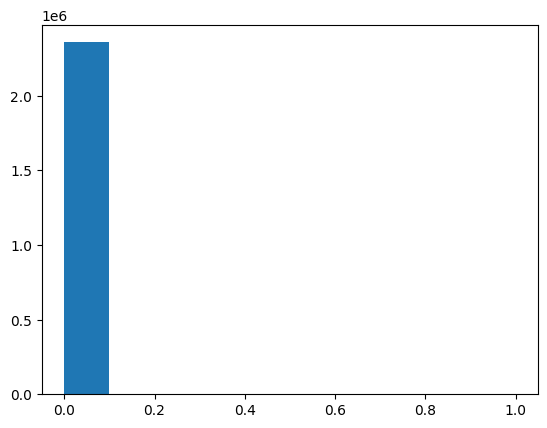

In [139]:
flat = attention.flatten()
flat_no_zero = flat[flat != 0]
plt.hist(flat_no_zero, bins=10);

In [141]:
z = get_sub_matrices(attention, 256, [(1, 1)])[0]

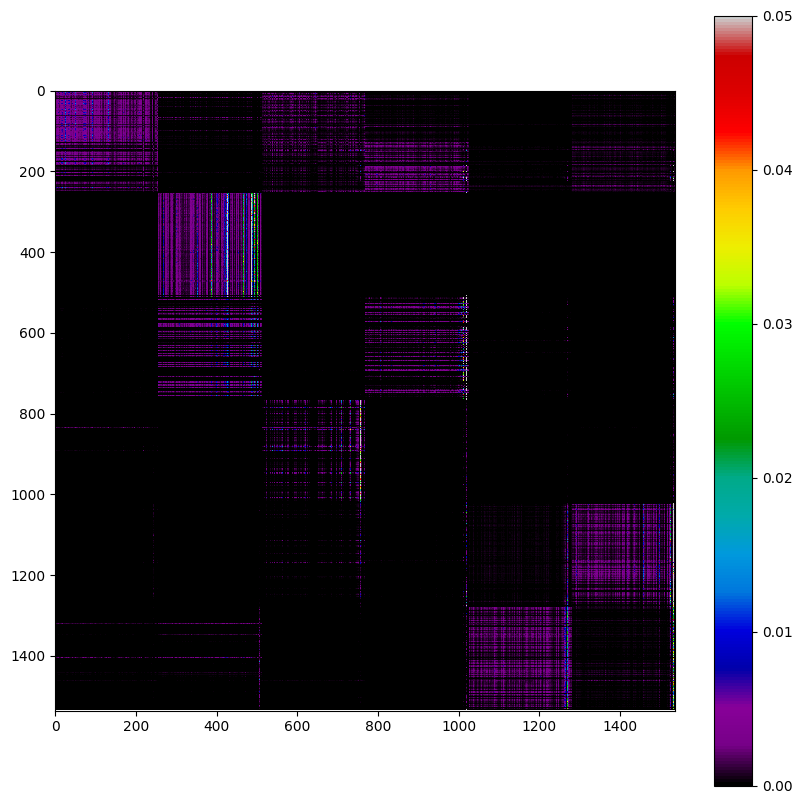

In [148]:
plt.figure(figsize=(10, 10))
plt.imshow(attention, cmap='nipy_spectral', interpolation='none', vmin=0, vmax=0.05)
plt.colorbar()

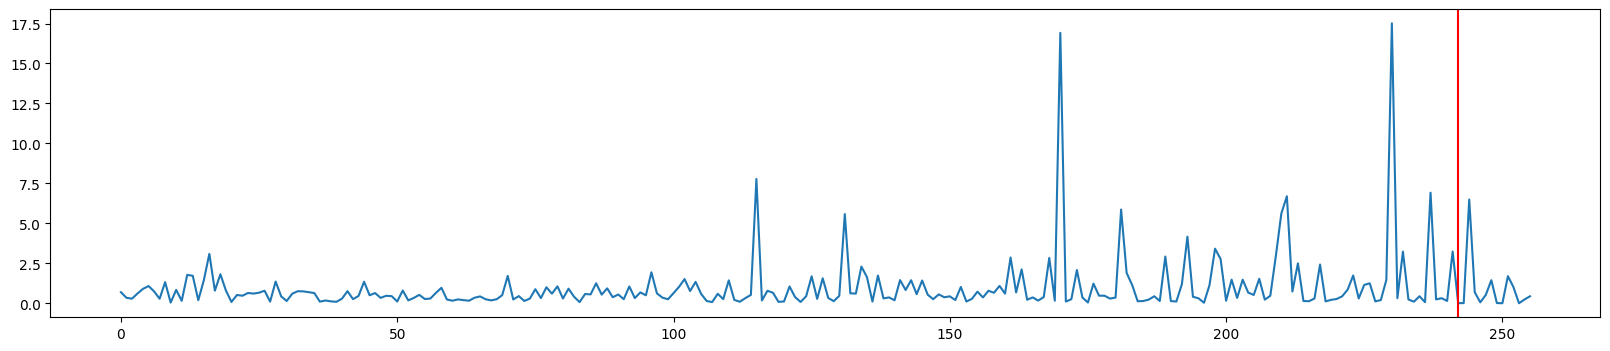

In [124]:
plt.figure(figsize=(20, 4))
plt.plot(z.sum(axis=0))
plt.axvline(242, color='r')

In [125]:
((249/2048)*1000)-(242/2048)*1000

3.41796875

In [126]:
import numpy as np
arr = np.zeros((6,6))
for x in range(6):
    for y in range(6):
        z = get_sub_matrices(attention, 256, [(x, y)])[0]
        arr[x, y] = z.sum()

In [127]:
np.set_printoptions(linewidth=100000, formatter=dict(float=lambda x: "%.3g" % x))
arr

array([[122, 7.57, 42.7, 53, 7.59, 22.6],
       [9.58e-05, 254, 0.553, 0.473, 1, 0.00157],
       [1.33, 60.7, 1.7, 180, 11.1, 0.758],
       [0.767, 0.000513, 252, 0.831, 1.61, 0.754],
       [1.5, 0.0201, 13.3, 4.16, 40.5, 197],
       [2.63, 5.56, 1.67, 1.58, 223, 21.7]])

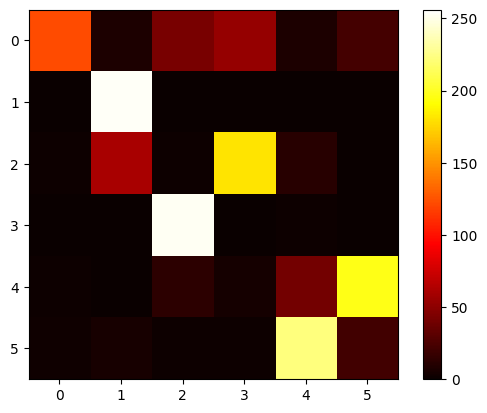

In [128]:
plt.imshow(arr, cmap='hot', interpolation='none', vmin=0, vmax=256)
plt.colorbar()

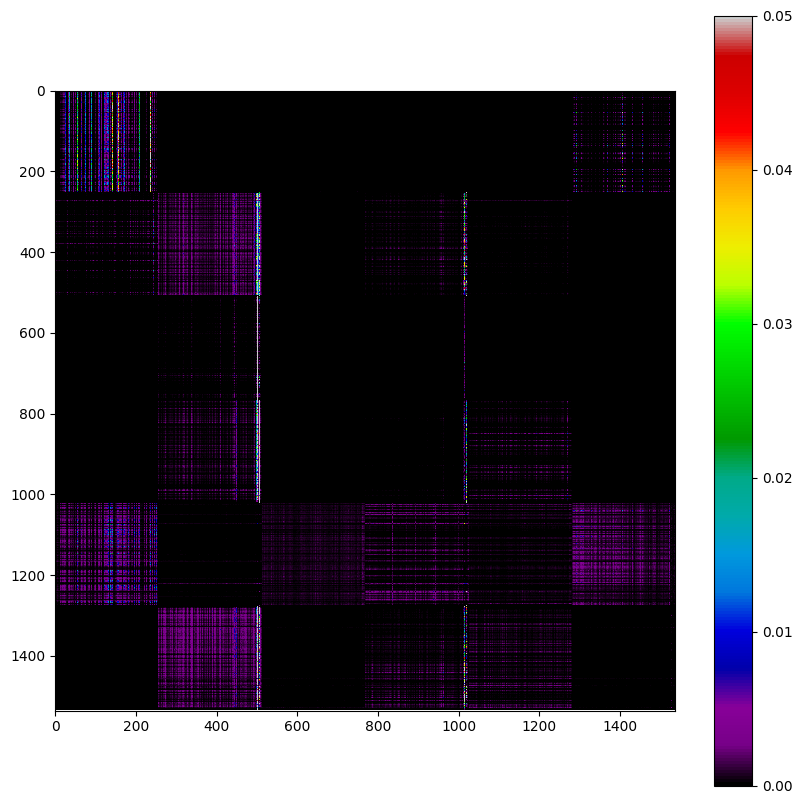

In [149]:
path = "/home/dan/Documents/images/offline-run-20240124_145027-bwvamicd/files/self_attn_1990_layer_0.npy"
attention = np.load(path)
attention = attention[0, 0, :, :]
def get_sub_matrices(A, Q, indices):
    sub_matrices = []
    M = A.shape[0]  # Assuming A is a numpy array and square

    for idx in indices:
        i, j = idx
        if i*Q < M and j*Q < M:  # Check if indices are valid
            sub_matrix = A[i*Q:(i+1)*Q, j*Q:(j+1)*Q]
            sub_matrices.append(sub_matrix)
        else:
            sub_matrices.append(None)  # Or handle invalid index differently

    return sub_matrices
import numpy as np
arr = np.zeros((6,6))
for x in range(6):
    for y in range(6):
        z = get_sub_matrices(attention, 256, [(x, y)])[0]
        arr[x, y] = z.sum()

# plt.imshow(arr, cmap='hot', interpolation='none', vmin=0, vmax=256)
# plt.colorbar()

plt.figure(figsize=(10, 10))
plt.imshow(attention, cmap='nipy_spectral', interpolation='none', vmin=0, vmax=0.05)
plt.colorbar()